# Intro to Random Forests

## About this course

### Teaching approach

This course is being taught by Jeremy Howard, and was developed by Jeremy along with Rachel Thomas.

### Books

People wanting to learn Python 3 as a first programming language, should have to take a look at 
[Learn Python 3 the Hard Way](https://www.amazon.com/gp/product/0134692888). If you're already a general purpose developer, but with no previous Python background, I recommend this book [Python Tricks: A Buffet of Awesome Python Features](https://www.amazon.es/Python-Tricks-Buffet-Awesome-Features/dp/1775093301). The more familiarity you have with numeric programming in Python, the better. If you're looking to improve in this area, we strongly suggest Wes McKinney's [Python for Data Analysis, 2nd ed](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1491957662/ref=asap_bc?ie=UTF8).

For machine learning with Python, we also recommend these books:
- [Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Andreas-Mueller/dp/1449369413): From one of the scikit-learn authors, which is the main library we'll be using
- [Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939/ref=dp_ob_title_bk): New version of a very successful book. A lot of the new material however covers deep learning in Tensorflow, which isn't relevant to this course
- [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=MBV2QMFH3EZ6B3YBY40K)

and some videos:

- [Introduction to Machine Learning for Coders!](http://course18.fast.ai/ml) This notebook is based on this course's notebooks
- [Practical Deep Learning for Coders, v3](https://course.fast.ai/videos/?lesson=1) Hands on deep learning course based on pytorch and fast.ai
- [Full Stack Deep Learning](https://fullstackdeeplearning.com/march2019#) Guide from start to end on how to develop a machine learning project

Finally, I recommend [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf) (free ebook) for a math & statistics approach to Machine Learning

## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, datetime
sys.path.insert(0,'../src')
from utils import *

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from pathlib import Path
import seaborn as sns

In [3]:
PATH_data = Path('..') / 'data' 

In [4]:
!ls {PATH_data}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!dir {PATH_data / 'raw'}

 Volume in drive C is Windows
 Volume Serial Number is 6E3A-9E35

 Directory of C:\Users\fran\work-plain\notebook\mlcourse\data\raw

23/05/2019  20:29    <DIR>          .
23/05/2019  20:29    <DIR>          ..
23/05/2019  20:26                 0 .gitkeep
29/04/2019  16:56        50,792,381 bluebook-for-bulldozers.zip
30/04/2019  16:04       116,403,970 Train.csv
               3 File(s)    167,196,351 bytes
               2 Dir(s)  188,378,300,416 bytes free


# Introduction to *Blue Book for Bulldozers*

## About...

### ...this dataset

We will be looking at the [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers) Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### ...Kaggle Competitions

[Kaggle](https://www.kaggle.com/) is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [8]:
# if you are running this notebook in Azure Notebook, uncomment following line and comment last line
#time df_raw = pd.read_csv(PATH_data / 'raw' / 'Train.csv', low_memory=False, parse_dates=["saledate"], nrows=200_000)
%time df_raw = pd.read_csv(PATH_data / 'raw' / 'Train.csv', low_memory=False, parse_dates=["saledate"])

Wall time: 40 s


In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [7]:
df_raw.tail().T

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [8]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_raw.describe(percentiles=[.5]).T

,count,mean,std,min,50%,max
SalesID,401125.0,1.919713e+06,909021.492667,1139246.0,1639422.0,6333342.0
SalePrice,401125.0,3.109971e+04,23036.898502,4750.0,24000.0,142000.0
MachineID,401125.0,1.217903e+06,440991.954249,0.0,1279490.0,2486330.0
ModelID,401125.0,6.889703e+03,6221.777842,28.0,4604.0,37198.0
datasource,401125.0,1.346658e+02,8.962237,121.0,132.0,172.0
auctioneerID,380989.0,6.556040e+00,16.976779,0.0,2.0,99.0
YearMade,401125.0,1.899157e+03,291.797469,1000.0,1995.0,2013.0
MachineHoursCurrentMeter,142765.0,3.457955e+03,27590.256413,0.0,0.0,2483300.0


Sometimes is very useful to slide the data, or apply some transformation to the data. Most of this kind of operations can be done using the `pandas` library. Take a look to the following commands:

In [62]:
# return an slice of columns
df_raw[['SalesID','SalePrice']].head(10)
# it's equivalent to
#df_raw.loc[:,['SalesID','SalePrice']]

,SalesID,SalePrice
0,1139246,66000
1,1139248,57000
2,1139249,10000
3,1139251,38500
4,1139253,11000
5,1139255,26500
6,1139256,21000
7,1139261,27000
8,1139272,21500
9,1139275,65000


In [63]:
# return an slice of rows and columns
df_raw.loc[10:20, ['SalesID','SalePrice']]

,SalesID,SalePrice
10,1139278,24000
11,1139282,22500
12,1139283,36000
13,1139284,30500
14,1139290,28000
15,1139291,19000
16,1139292,13500
17,1139299,9500
18,1139301,12500
19,1139304,11500


In [64]:
# where filtering
df_raw[(df_raw.fiModelDesc=='35NX2') & (df_raw.datasource==132)]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
284581,1903045,14000,1277896,21439,132,1.0,2005,826.0,Low,2009-02-19,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
284582,1903046,12500,1520060,21439,132,12.0,2007,NaN,NaN,2009-01-21,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [66]:
# group by column and aggregation
df_raw[['YearMade','SalesID']].groupby('YearMade').count().head()

,SalesID
YearMade,
1000,38185
1919,127
1920,17
1937,1
1942,1


In [69]:
df_raw[['YearMade','UsageBand','SalesID']].groupby('YearMade').agg({'SalesID': 'count','UsageBand': ['count','size','nunique']}).head()

SalesID UsageBand               
           count     count   size nunique
YearMade                                 
1000       38185      5061  38185       3
1919         127         1    127       1
1920          17         0     17       0
1937           1         0      1       0
1942           1         0      1       0

In [72]:
df_raw[['YearMade','UsageBand']].groupby('YearMade').agg({'UsageBand': set}).head()

,UsageBand
YearMade,
1000,"{Medium, nan, Low, High}"
1919,"{nan, Low}"
1920,{nan}
1937,{nan}
1942,{nan}


> <span style="color:blue">Practical Exercise</span>: Calculate: 
* (min,mean,max) Sale Price by Year
* age of each vehicle (datetime.date.today().year - YearMade

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need (in the following section we will explain RMSE)

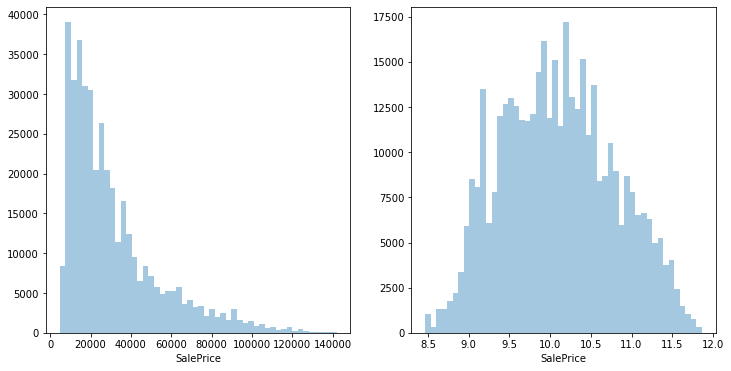

In [90]:
_, axes = plt.subplots(1, 2, figsize=(12,6))
sns.distplot(df_raw.SalePrice, ax=axes[0], kde=False)
sns.distplot(np.log(df_raw.SalePrice),ax=axes[1], kde=False)

In [10]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

### Initial processing

In [11]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Low'

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

First, we are going to extract important features from saledate, using the method `add_datepart`

In [91]:
add_datepart(df_raw, 'saledate')
df_raw.filter(regex=("sale.*")).head()

,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleEpoch
0,2006,11,46,16,3,320,False,False,False,False,False,False,1163635200
1,2004,3,13,26,4,86,False,False,False,False,False,False,1080259200
2,2004,2,9,26,3,57,False,False,False,False,False,False,1077753600
3,2011,5,20,19,3,139,False,False,False,False,False,False,1305763200
4,2009,7,30,23,3,204,False,False,False,False,False,False,1248307200


Second, we will inspect the dataframe column types. Most machine learning models require that non-numerical columns should be transformed to numerical. This is another easy transformation we can get using the Categorical type.

In [92]:
df_raw_columns_by_type = df_raw.columns.to_series().groupby(df_raw.dtypes).groups
df_raw_columns_by_type

{dtype('bool'): Index(['saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
        'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start'],
       dtype='object'),
 dtype('int64'): Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
        'YearMade', 'saleYear', 'saleMonth', 'saleWeek', 'saleDay',
        'saleDayofweek', 'saleDayofyear', 'saleEpoch'],
       dtype='object'),
 dtype('float64'): Index(['auctioneerID', 'MachineHoursCurrentMeter'], dtype='object'),
 dtype('O'): Index(['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
        'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
        'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
        'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
        'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
        'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
        'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',

In [93]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

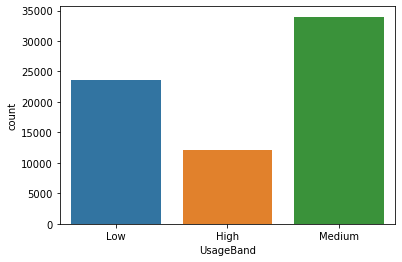

In [94]:
sns.countplot (df_raw.UsageBand);

In [95]:
df_raw.UsageBand.value_counts(dropna=False)

NaN       331486
Medium     33985
Low        23620
High       12034
Name: UsageBand, dtype: int64

In order convert a column to Categorical, we can use the `astype('category')` pandas method. The resulting column will contain an index that references the original value of the data. This transformation also takes care of all missing data, which is assigned the category code -1.

In [96]:
usage_band_categories = df_raw.UsageBand.astype('category')
usage_band_categories.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

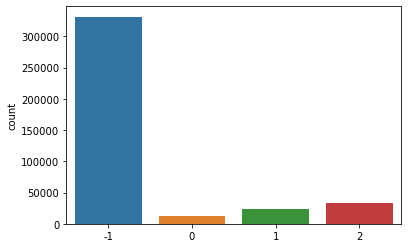

In [97]:
sns.countplot (usage_band_categories.cat.codes);

We can specify the order to use for categorical variables if we wish:

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [98]:
df_raw.to_parquet(PATH_data / 'processed' / 'train.parquet')

### Pre-processing

In the future we can simply read it from this fast format.

In [99]:
%time df_raw = pd.read_parquet(PATH_data / 'processed' / 'train.parquet')

Wall time: 1.15 s


We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [100]:
columns_cat = df_raw.select_dtypes('object').head().columns.values.tolist()
columns_cont = df_raw.columns.symmetric_difference(columns_cat)

In [101]:
for col in columns_cat:
    df_raw[col] = df_raw[col].astype('category').cat.codes

In [102]:
#df_raw.dtypes.to_frame().applymap(str).reset_index().groupby(0).agg({'index':list}).to_dict()['index']
df_raw.columns.to_series().groupby(df_raw.dtypes).groups

{dtype('bool'): Index(['saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
        'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start'],
       dtype='object'),
 dtype('int8'): Index(['UsageBand', 'fiModelSeries', 'ProductSize', 'fiProductClassDesc',
        'state', 'ProductGroup', 'ProductGroupDesc', 'Drive_System',
        'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick',
        'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width',
        'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock',
        'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler',
        'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
        'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
        'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
        'Differential_Type', 'Steering_Controls'],
       dtype='object'),
 dtype('int16'): Index(['fiModelDesc', 'fiBaseModel', 'fiSeconda

We're still not quite done - for instance we have some missing values, which we can't pass directly to a random forest.

In [103]:
display_all(df_raw.isnull().sum()/len(df_raw)) # proportion of missing values (NA's)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.050199
YearMade                    0.000000
MachineHoursCurrentMeter    0.644089
UsageBand                   0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.000000
fiModelSeries               0.000000
fiModelDescriptor           0.000000
ProductSize                 0.000000
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.000000
Enclosure                   0.000000
Forks                       0.000000
Pad_Type                    0.000000
Ride_Control                0.000000
Stick                       0.000000
Transmission                0.000000
Turbocharged                0.000000
B

In this case, we replace NA's by the median of the column, but there exists more strategies to deal with NA's (google for _imputation methods_):
- Remove row / column
- Replace by Zero / Mean / Median / Mode
- Linear regression
- Soft imputation
- Add boolean column isNA

In [104]:
df_raw.fillna(df_raw.median(), inplace=True)

In [109]:
assert (df_raw.isnull().sum() == 0).all()

In [106]:
df_raw.to_parquet(PATH_data / 'interim' / 'train.parquet')

We now have something we can pass to a random forest!

In [110]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
# data leaking: .drop(columns=['SalePrice'])
%time m.fit(df_raw.drop(columns=['SalePrice']), df_raw.SalePrice)

Wall time: 24.4 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

The method `score()` of the model returns the R^2 metric.

In [29]:
m.score(df_raw.drop(columns=['SalePrice']), df_raw.SalePrice)

0.9829687251245827

We evaluate machine learning models using **scoring metrics**. As mentioned  before, the original Kaggle competition uses RMSLE, but for our purposes we will use another metric called R^2 (aka as R-squared or [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)). This metric measures the percentage of variance explained by the model, so the value of this metric ranges between 0 and 1 (the higher the better). The definition is as follows:

$$r^2=1-\frac{RSS}{TSS}=1-\frac{\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$$

> <span style="color:blue">Practical Exercise</span>: RMSLE comes from RMSE, which is a very common metric, defined as follows:
> $$RMSE = \sqrt{\frac{\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}{n}}$$
> Develop a function that accepts a random forest model (m), a dataframe containing the features (X_train) and another dataframe containing the labels (y_train), and returns the RMSE value

### validation set

Wow, an R^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** (and one of the differences respect Statistical methods) in Machine Learning  is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="../references/overfitting.png" alt="" style="width: 70%"/>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem. [Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)

In [30]:
df = df_raw.drop(columns=['SalePrice'])
y = df_raw.SalePrice

In [31]:
n_valid = 12_000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 64), (389125,), (12000, 64))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [32]:
import pprint

def print_score(m):
    output = {
        'RMSE train' : rmse(m.predict(X_train), y_train),
        'RMSE val'   : rmse(m.predict(X_valid), y_valid),
        'R^2 train'  : m.score(X_train, y_train),
        'R^2 val'    : m.score(X_valid, y_valid)
    }
    if hasattr(m, 'oob_score_'): 
        output['R^2 oob'] = m.oob_score_
    
    pprint.pprint (output)

In [33]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 14.5 s
{'RMSE train': 0.09043032760628343,
 'RMSE val': 0.25205270094555626,
 'R^2 train': 0.9829091747176163,
 'R^2 val': 0.8865431595345604}


We are using a helping method named `print_score()` which display main metrics of the model. Besides the R^2 mentioned before, now we display also the RMSE.

An R^2 in the high-80's isn't bad at all, but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [34]:
df_subsample = df_raw.sample(n=30_000)
X_train, _ = split_vals(df_subsample.drop(columns=['SalePrice']), 20_000)
y_train, _ = split_vals(df_subsample.SalePrice, 20_000)

In [35]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 579 ms
{'RMSE train': 0.11836983582318655,
 'RMSE val': 0.29024274423408564,
 'R^2 train': 0.9708432722034234,
 'R^2 val': 0.849557439205607}


stochastic processes: randomness is involved in building the model

In [36]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 567 ms
{'RMSE train': 0.11713856233302755,
 'RMSE val': 0.28494357105061874,
 'R^2 train': 0.9714466893118996,
 'R^2 val': 0.8550007688019335}


In [37]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10, random_state=42)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 567 ms
{'RMSE train': 0.11676315722826704,
 'RMSE val': 0.2903199053101922,
 'R^2 train': 0.9716294110763314,
 'R^2 val': 0.8494774382191971}


In [38]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10, random_state=42)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 466 ms
{'RMSE train': 0.11676315722826702,
 'RMSE val': 0.29031990531019225,
 'R^2 train': 0.9716294110763314,
 'R^2 val': 0.8494774382191971}


## Single tree

When we disable bootstrap in random forest, we take out the "randomness" of the process, so the resulting tree takes all available samples (max_sample=1)

In [39]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.5413421979652534,
 'RMSE val': 0.5665330762538584,
 'R^2 train': 0.39018169610207376,
 'R^2 val': 0.4268101184613302}


In order to visualize the following tree, you need to install [GraphViz - Windows Packages](https://graphviz.gitlab.io/_pages/Download/Download_windows.html)

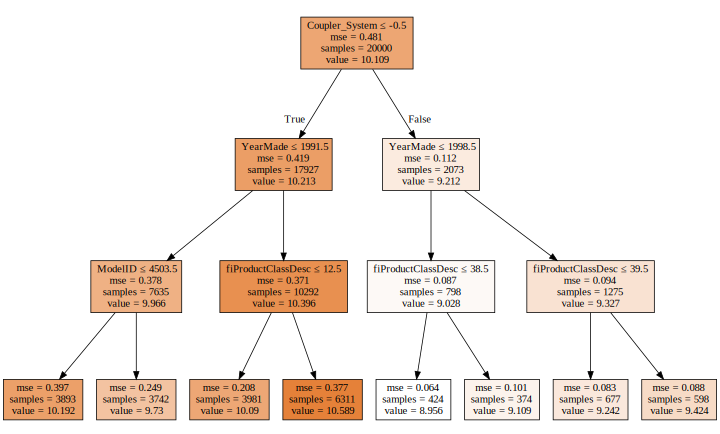

In [40]:
draw_tree(m.estimators_[0], X_train, precision=3)

Here’s an understanding of tree and its parameters.

1. Feature name
Feature at every node is decided after selecting a feature from a subset of all features.
Feature selection based on Mean Squared Error (${\frac{\sum_{i=1}^{n}(y_i-\hat{y}_i)^2}{n}}$) or gini (or information gain) (gini is commonly used because it is less computational complex).

2. Split value — split value is decided after selecting a threshold value which gives highest MSE (regression) or gini (classification) for that split

3. MSE (or gini) — It is basically deciding factor i.e. to select feature at next node , to pick best split value etc.

4. Samples — Number of samples remaining at that particular node.

5. Value — Mean value of the samples at this node. In case of regression, is the average of the labels under this tree / leaf. In case of classication, number of samples of each class remaining at that particular node (theoretically sum of these values equals Samples value)

The learning curve is another tool commonly used to represent the fitness of the model. Usually plots the improvement of the model (loss function) respect training time / number of samples / epochs or any other kind of measure that changes by time.

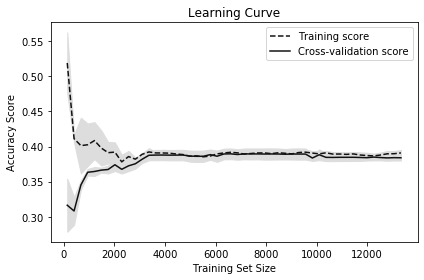

In [41]:
plot_learning_curve(m, X_train, y_train)

Let's see what happens if we create a bigger tree. With enogh depth in the tree, and with no bootstrapping at all, the random forest is able to memorize the whole dataset (R^2 train equals **1**)

In [42]:
#max_depth:None = nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
m = RandomForestRegressor(n_estimators=1, max_depth=None, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 6.526751786450488e-17,
 'RMSE val': 0.38123872765597366,
 'R^2 train': 1.0,
 'R^2 val': 0.7404374710349209}


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

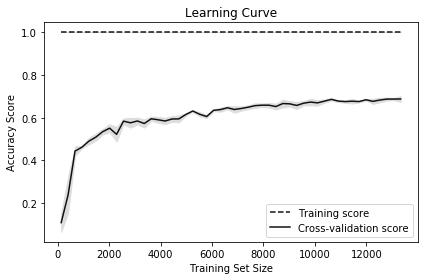

In [43]:
plot_learning_curve(m, X_train, y_train)

## Bagging

### Intro to bagging

Random Forest = Bag of Little Bootstraps

To learn about bagging in random forests, let's start with our basic model again.

In [44]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.11646202826823164,
 'RMSE val': 0.2836368862578401,
 'R^2 train': 0.971775556312458,
 'R^2 val': 0.8563275849218275}


We'll grab the predictions for each individual tree (`estimators_`), and look at one example, taking the average of all trees and compare with the actual value

In [45]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds.shape

(10, 12000)

In [46]:
assert preds.shape[0] == len(m.estimators_) == m.n_estimators
assert preds.shape[1] == X_valid.shape[0]

In [47]:
preds[:,0], np.mean(preds[:,0]), m.predict([X_valid.iloc[0]])[0], y_valid.iloc[0]

(array([9.15904708, 9.43348392, 9.61580548, 9.51044496, 9.30565055,
        9.10497986, 8.98719682, 9.30565055, 9.21034037, 9.6485953 ]),
 9.328119490081477,
 9.328119490081475,
 9.104979856318357)

As we keep adding trees, the rmse score improves (one tree is not worth it, but all combined trees are worth it)

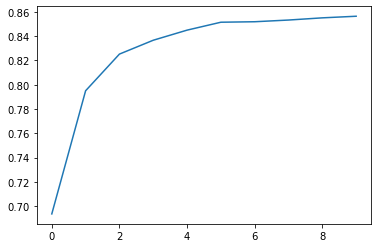

In [48]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

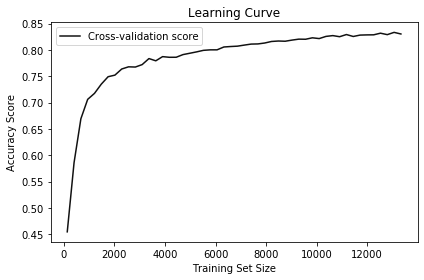

In [49]:
plot_learning_curve(m, X_train, y_train, plot_training = False, plot_ci=False)

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [50]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.10658049458043468,
 'RMSE val': 0.27681583962072775,
 'R^2 train': 0.9763619223858546,
 'R^2 val': 0.8631547118731611}


In [51]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.10071073456137891,
 'RMSE val': 0.27366329512932863,
 'R^2 train': 0.978893888938536,
 'R^2 val': 0.8662539151361386}


In [52]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.09776331292853471,
 'RMSE val': 0.2706708544842696,
 'R^2 train': 0.9801112031296854,
 'R^2 val': 0.8691628841836497}


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [53]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.1004611368139422,
 'RMSE val': 0.27162205430076947,
 'R^2 oob': 0.8494588312961538,
 'R^2 train': 0.9789983765037661,
 'R^2 val': 0.868241684760584}


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling  [`set_rf_samples`]

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [54]:
X_train, X_valid = split_vals(df_raw.drop(columns=['SalePrice']), n_trn)
y_train, y_valid = split_vals(df_raw.SalePrice, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [55]:
set_rf_samples(20000)

In [56]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 3.62 s
{'RMSE train': 0.24111151970200612,
 'RMSE val': 0.2742625856642506,
 'R^2 oob': 0.8657625384063528,
 'R^2 train': 0.8785015473944907,
 'R^2 val': 0.8656674972514828}


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [57]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.22663847872609455,
 'RMSE val': 0.26033229252700074,
 'R^2 oob': 0.8811497392087819,
 'R^2 train': 0.8926499826730953,
 'R^2 val': 0.8789669271004038}


In [58]:
#plot_learning_curve(m, X_train, y_train)

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [59]:
reset_rf_samples()

### Tree building parameters

Let's get a baseline for this full set to compare to.

In [60]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.07840510254248377,
 'RMSE val': 0.2373746883612862,
 'R^2 oob': 0.9084781035438318,
 'R^2 train': 0.9871523564051522,
 'R^2 val': 0.899372475444222}


One factor of complexity is the estimator (tree) depth, so if we reduce it, the model will overfit less

In [61]:
t=m.estimators_[0].tree_
dectree_max_depth(t)

47

In [62]:
max([dectree_max_depth(est.tree_) for est in m.estimators_])

52

In [63]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.14084063354346227,
 'RMSE val': 0.23467371692718303,
 'R^2 oob': 0.9070298223435956,
 'R^2 train': 0.9585436782715785,
 'R^2 val': 0.9016494307179024}


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with **`min_samples_leaf`**) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility
- recommended values: `[1, 3, 5, 10, 25, 100]`

In [64]:
#t=m.estimators_[0].tree_
#dectree_max_depth(t)
min([dectree_max_depth(est.tree_) for est in m.estimators_])

33

In [65]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.11504234204816781,
 'RMSE val': 0.23285508210481992,
 'R^2 oob': 0.9083792859413109,
 'R^2 train': 0.9723401223199983,
 'R^2 val': 0.9031678854326243}


In [66]:
#t=m.estimators_[0].tree_
#dectree_max_depth(t)
min([dectree_max_depth(est.tree_) for est in m.estimators_])

37

In [67]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

{'RMSE train': 0.11923358821227545,
 'RMSE val': 0.2268973912903239,
 'R^2 oob': 0.9118450821926619,
 'R^2 train': 0.9702879885552022,
 'R^2 val': 0.9080594749910091}


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying **`max_features`**, which is the proportion of features to randomly select from at each split.
- recommended values: `[None, 0.5, sqrt]`

In [68]:
#t=m.estimators_[0].tree_
#dectree_max_depth(t)
min([dectree_max_depth(est.tree_) for est in m.estimators_])

38

In [69]:
m

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

> <span style="color:blue">Practical Exercise</span>: Check if you can get a better model, by changing the values of the hyperparameters `max_features`, `min_samples_leaf` and `n_estimators`. These parameters are well documented (run `? RandomForestRegressor` command), but you can also test using other hyperparameters.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models. The green line represents trees that take all the features, but this approach get worse results: not always pays better to take all the data, but column sampling works much better.
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

### Finding best hyperparameters using Grid Search

Grid Search is a term related to finding the best hyperparameters. We can preset some values to use, and then grid search tries every combination and calculates best improvements using cross validation.

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
parameters = {'max_features': [None, 0.5, 'sqrt'], 
              'min_samples_leaf': [1, 5, 10, 25, 100], 
              'n_estimators': [10, 25, 50],
              'oob_score': [False] }

In [72]:
gs = GridSearchCV(m, parameters, cv=3)
%time gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [None, 0.5, 'sqrt'], 'min_samples_leaf': [1, 3, 5, 10, 25, 100], 'n_estimators': [10, 20, 40, 50], 'oob_score': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [74]:
print_score(gs.best_estimator_)

{'RMSE train': 0.14436694035485167,
 'RMSE val': 0.22795183429392457,
 'R^2 train': 0.9564417592691348,
 'R^2 val': 0.907202952950095}


In [75]:
t=gs.best_estimator_.estimators_[0].tree_
dectree_max_depth(t)

37

In [76]:
max([dectree_max_depth(est.tree_) for est in gs.best_estimator_.estimators_])

45

In [77]:
pd.DataFrame([dectree_max_depth(est.tree_) for est in gs.best_estimator_.estimators_]).describe(percentiles=[.5])[0].to_dict()

{'count': 50.0,
 'mean': 37.72,
 'std': 2.0902104180767864,
 'min': 35.0,
 '50%': 37.0,
 'max': 45.0}